In [83]:
import numpy as np
import math
import residuals as r
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True)

In [170]:
# I am defining the weighted standard deviation according to this definition:
# https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_variance
# I am using the inverse square of the error arrays to define the weights

# factor10 = math.sqrt((25*60)/10.0) 
# factor80 = math.sqrt((25*60)/80.0) 


def weighted_stddev(values, errors):
    '''
    Return the weighted average and standard deviation.

    '''
    weights = 1. / ((errors)**2)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (math.sqrt(variance))

def magnitude(x):
    var = float(x)
    return int(math.floor(math.log10(var)))


def jitter_ratio(psrname, MJDint, condition_lower, condition_upper):
    '''
    Prints the ratio of sigma_dump over sigma_all.
    
    Prints the correlation coefficient too, so we can easily compare here.
    
    Requires residuals in four time resolutions: 80s, 40s, 20s and NT intervals.

    '''
    
    jitter_ratios = OrderedDict()
    corr_coefs = OrderedDict()
    for elem in ['320','160','80', '40', '20', 'NT']:
    
        #Define sigma_all (or std_all) as entire observation period
        x=r.read_residuals(filename="/nimrod1/eschwab/residuals/%s_resid_%s_%sF8.tmp" %(psrname, MJDint, elem))

        condition = (x.bary_TOA > condition_lower) & (x.bary_TOA < condition_upper)
        Resid_all = x.prefit_sec[condition]
        Errors_all = x.uncertainty[condition]
        std_all = weighted_stddev(Resid_all, Errors_all)

        ##============

        #Define sigma_dump (or std_all) as individual dumps within observation period

        #This isolates the numbers for the different dump times
        rounded = np.round(np.array([x.bary_TOA[condition] - 0.00005]), 4)
        dumptimes=[]
        for i in rounded.tolist()[0]: 
            if i not in dumptimes:
                dumptimes.append(i)

        #This calculates a list of sigma_dump values and averages those
        str_dump_devs=[]
        for i in dumptimes:
            timeindex = (rounded == i)[0]
            Resid = Resid_all[timeindex]
            Errors = Errors_all[timeindex]
            single_std_dump = weighted_stddev(Resid, Errors)
            str_dump_devs.append(single_std_dump)

        #to convert str_dump_devs out of scientific notation
        dump_devs=[]
        for i in str_dump_devs:
            dump_devs.append('{0:.20f}'.format(i))

        #prints the magnitude of each sigma_dump in a list and finds average magnitude
        magarray=[]
        for i in dump_devs:
            magarray.append(magnitude(i))
        averagemag = round(np.mean(magarray))

        arg=averagemag+1.5
        makemask = np.ma.masked_where(np.array(magarray) > arg, np.array(magarray))

        std_dump=np.mean(str_dump_devs)
        masked_std_dump = np.mean(np.ma.masked_where(np.ma.getmask(makemask), str_dump_devs))

        #Setup jitter ratio
        ratio = std_all / std_dump
        masked_ratio = float(std_all / masked_std_dump)
        jitter_ratios[elem] = masked_ratio

        ##============

        #Print out the correlation coefficient also, to allow for easy reference

        #Creating the matrix of the data and transposing it to correct format
        data = []
        data_errors = []
        for i in dumptimes[1:]: #the first set of resids needs to be skipped in J1713, but not sure for all of them?
            timeindex = (rounded == i)[0]
            Resids = Resid_all[timeindex]
            Errors = Errors_all[timeindex]
            data.append(Resids)
            data_errors.append(Errors)

        data = map(list, zip(*data)) #transposing the matrix, supposedly unnecessary if rowvar=0 in corr but gives errors

        #Using the Weighted Correlation Coefficient from wikipedia
        #https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient#Weighted_correlation_coefficient
        # I added weights by creating a weighted value to multiply each data element by
        #The weighted values are normalized by dividing each value by the sum of all weights

        data_weights = 1. / (np.array(data_errors)**2)
        data_weights = map(list, zip(*(data_weights.tolist())))

        #data_weights is a matrix of all the weights

        norm_weights = []
        for i in data_weights:
            norm_weights.append([j/sum(i) for j in i])

        weighted_data = []
        for i,j in zip(data, norm_weights):
            weighted_data.append([a*b for a,b in zip(i,j)])

        #Correlating! 
        corr = np.corrcoef(data)
        weighted_corr = np.corrcoef(weighted_data)

        unique_corrs = []
        #Averaging the correlation
        for i in range(len(corr)):
            unique_corrs.append(corr[i][i+1:]) #because numpy array, double index necessay
        unique_corrs  = [val for sublist in unique_corrs for val in sublist]
        final_coefficient = np.average(unique_corrs)

        unique_weighted_corrs = []
        #Averaging the correlation
        for i in range(len(weighted_corr)):
            unique_weighted_corrs.append(weighted_corr[i][i+1:]) #because numpy array, double index necessay
        unique_weighted_corrs  = [val for sublist in unique_weighted_corrs for val in sublist]
        final_weighted_coefficient = np.average(unique_weighted_corrs)
        
        corr_coefs[elem] = final_coefficient

        print "%s, MJD %s, %s second subintervals" %(psrname, MJDint, elem)
        print "sigma_all = " + str(std_all)
        print "average sigma_dump = " + str(std_dump)
        print "jitter ratio = " + str(ratio) 
        print "masked jitter ratio = " + str(masked_ratio) 
        print "correlation coefficient = " + str(final_coefficient)
        print "weighted correlation coefficient = " + str(final_weighted_coefficient)
        print '##========'
        print ' '

    #Now plotting the jitter ratios for all four time scrunches

    fig = plt.figure(figsize=(17,4))
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(range(len(jitter_ratios)), jitter_ratios.values(), c='blue')
    ax1.scatter(range(len(jitter_ratios)), jitter_ratios.values(), c='blue')
    ax1.set_ylabel('Jitter Ratio \n ($\sigma_A$ / $\sigma_D$)', fontsize='14')
    ax1.locator_params(nbins=4)
    
    ax2 = fig.add_subplot(2,1,2, sharex=ax1)
    ax2.plot(range(len(corr_coefs)), corr_coefs.values(), c='green')
    ax2.scatter(range(len(corr_coefs)), corr_coefs.values(), c='green')
    ax2.set_ylabel('Correlation \n Coefficient', fontsize=14)
    ax2.locator_params(nbins=4)

    plt.xticks(range(len(jitter_ratios)), jitter_ratios.keys())
    plt.gca().invert_xaxis()
    
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    plt.xlabel('Subinterval Duration', fontsize='14')
    plt.savefig('products/%s_%s_jr.png' %(psrname, MJDint))
    plt.show()

J1713+0747, MJD 56380, 320 second subintervals
sigma_all = 4.99134074834e-08
average sigma_dump = 1.55485083755e-08
jitter ratio = 3.21017336699
masked jitter ratio = 3.21017336699
correlation coefficient = 0.895481462748
weighted correlation coefficient = 0.872501349071
##========
 
J1713+0747, MJD 56380, 160 second subintervals
sigma_all = 1.02724678544e-07
average sigma_dump = 2.08155705723e-08
jitter ratio = 4.93499220631
masked jitter ratio = 4.93499220631
correlation coefficient = 0.913384095673
weighted correlation coefficient = 0.892085040895
##========
 
J1713+0747, MJD 56380, 80 second subintervals
sigma_all = 2.36009619379e-07
average sigma_dump = 2.46367746732e-08
jitter ratio = 9.57956642093
masked jitter ratio = 9.57956642093
correlation coefficient = 0.973712009848
weighted correlation coefficient = 0.911443650837
##========
 
J1713+0747, MJD 56380, 40 second subintervals
sigma_all = 3.69193384729e-07
average sigma_dump = 3.72086710682e-08
jitter ratio = 9.92224054582
ma

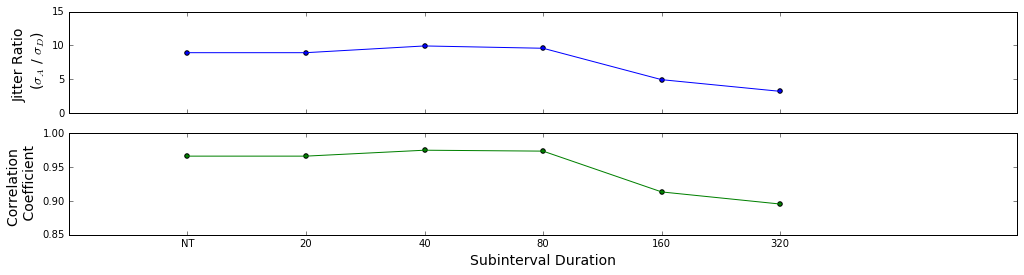

In [171]:
jitter_ratio("J1713+0747", "56380", 56380.35, 56380.367)

J1713+0747, MJD 56201, 320 second subintervals
sigma_all = 1.28349375934e-07
average sigma_dump = 3.35996387297e-08
jitter ratio = 3.81996297538
masked jitter ratio = 3.81996297538
correlation coefficient = 0.965867973918
weighted correlation coefficient = 0.92142164053
##========
 
J1713+0747, MJD 56201, 160 second subintervals
sigma_all = 1.14636932227e-07
average sigma_dump = 3.58651960885e-08
jitter ratio = 3.19632804862
masked jitter ratio = 3.19632804862
correlation coefficient = 0.882951876734
weighted correlation coefficient = 0.829805728781
##========
 
J1713+0747, MJD 56201, 80 second subintervals
sigma_all = 1.72172806927e-07
average sigma_dump = 3.95870217604e-08
jitter ratio = 4.34922354021
masked jitter ratio = 4.34922354021
correlation coefficient = 0.869429434589
weighted correlation coefficient = 0.833926967005
##========
 
J1713+0747, MJD 56201, 40 second subintervals
sigma_all = 3.29371498539e-07
average sigma_dump = 4.78985751379e-08
jitter ratio = 6.87643625287
mas

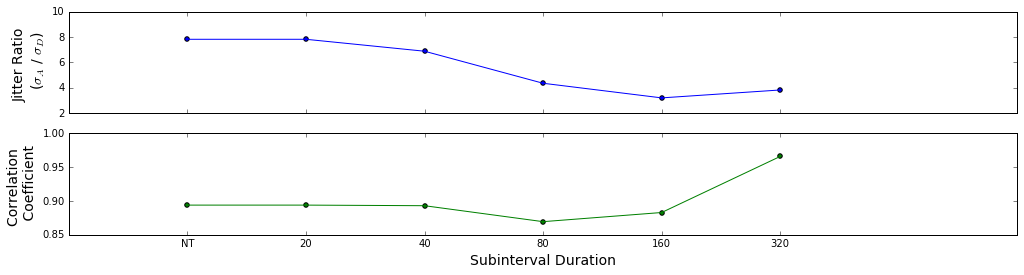

In [172]:
jitter_ratio("J1713+0747", "56201",
            56201.85, 56201.872)

B1937+21, MJD 56465, 320 second subintervals
sigma_all = 4.34350652792e-08
average sigma_dump = 4.29443683448e-08
jitter ratio = 1.01142633955
masked jitter ratio = 1.01142633955
correlation coefficient = -0.0976361651422
weighted correlation coefficient = 0.0459115821267
##========
 
B1937+21, MJD 56465, 160 second subintervals
sigma_all = 4.49408576e-08
average sigma_dump = 4.31623263629e-08
jitter ratio = 1.04120563897
masked jitter ratio = 1.04120563897
correlation coefficient = 0.0544794486294
weighted correlation coefficient = 0.829608463928
##========
 
B1937+21, MJD 56465, 80 second subintervals
sigma_all = 4.68059107539e-08
average sigma_dump = 4.44210286622e-08
jitter ratio = 1.05368813293
masked jitter ratio = 1.05368813293
correlation coefficient = 0.0816201709277
weighted correlation coefficient = 0.506229938622
##========
 
B1937+21, MJD 56465, 40 second subintervals
sigma_all = 5.147566038e-08
average sigma_dump = 4.51903627008e-08
jitter ratio = 1.13908491332
masked jit

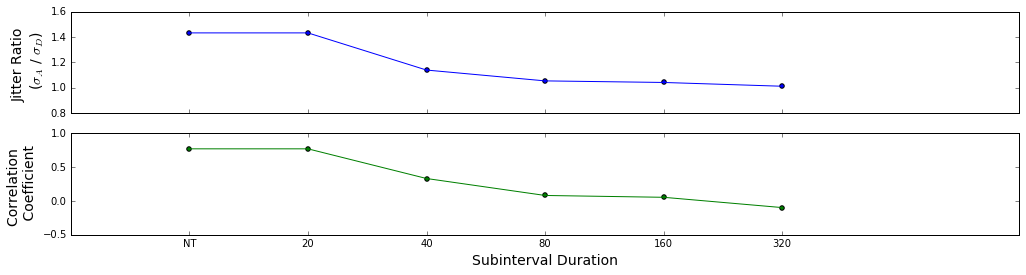

In [173]:
jitter_ratio("B1937+21", "56465",
            56465.3, 56465.32)

J1022+1001, MJD 57208, 320 second subintervals
sigma_all = 3.121586189e-05
average sigma_dump = 1.99039366818e-05
jitter ratio = 1.56832602459
masked jitter ratio = 1.56832602459
correlation coefficient = 0.5
weighted correlation coefficient = 0.142857142857
##========
 
J1022+1001, MJD 57208, 160 second subintervals
sigma_all = 2.07243623984e-05
average sigma_dump = 1.98330451922e-05
jitter ratio = 1.04494101625
masked jitter ratio = 1.04494101625
correlation coefficient = 0.0936496652722
weighted correlation coefficient = 0.315439478856
##========
 
J1022+1001, MJD 57208, 80 second subintervals
sigma_all = 4.6866049668e-05
average sigma_dump = 0.000296708047933
jitter ratio = 0.157953415806
masked jitter ratio = 3.33695161071
correlation coefficient = -0.0908035595199
weighted correlation coefficient = 0.173805858185
##========
 
J1022+1001, MJD 57208, 40 second subintervals
sigma_all = 7.30075922469e-05
average sigma_dump = 0.000368185703827
jitter ratio = 0.19829013318
masked jitte

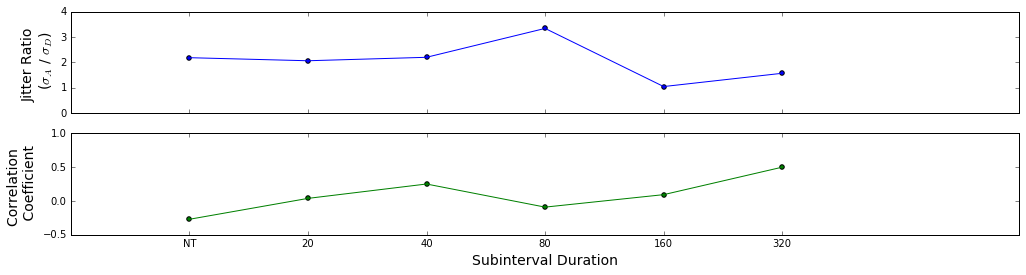

In [174]:
jitter_ratio("J1022+1001", "57208", 57208.778, 57208.79)

J1022+1001, MJD 57331, 320 second subintervals
sigma_all = 1.13754420364e-06
average sigma_dump = 7.98479238765e-07
jitter ratio = 1.42463842316
masked jitter ratio = 1.42463842316
correlation coefficient = 0.538537666949
weighted correlation coefficient = 0.247508421503
##========
 
J1022+1001, MJD 57331, 160 second subintervals
sigma_all = 1.14261427199e-06
average sigma_dump = 8.17265859715e-07
jitter ratio = 1.39809372729
masked jitter ratio = 1.39809372729
correlation coefficient = 0.476564711032
weighted correlation coefficient = 0.270408318247
##========
 
J1022+1001, MJD 57331, 80 second subintervals
sigma_all = 1.65569569649e-06
average sigma_dump = 1.43649632382e-06
jitter ratio = 1.15259306204
masked jitter ratio = 1.15259306204
correlation coefficient = 0.131051206325
weighted correlation coefficient = 0.209338838827
##========
 
J1022+1001, MJD 57331, 40 second subintervals
sigma_all = 4.06177566146e-06
average sigma_dump = 2.83124392539e-06
jitter ratio = 1.43462582826
ma

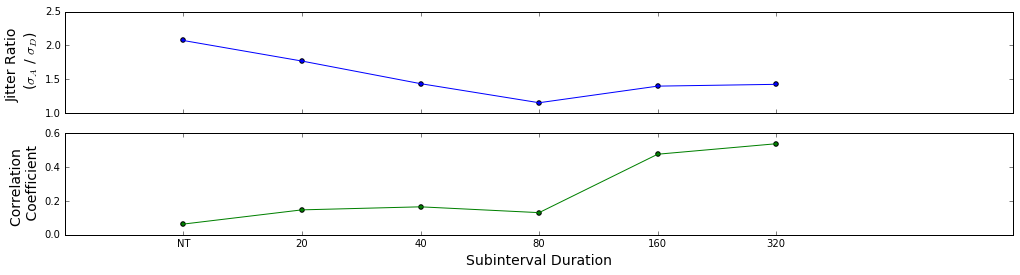

In [175]:
jitter_ratio("J1022+1001", "57331",
            57331.443, 57331.4595)

J2317+1439, MJD 57273, 320 second subintervals
sigma_all = 7.41903525814e-05
average sigma_dump = 7.37767094648e-05
jitter ratio = 1.00560668969
masked jitter ratio = 1.00560668969
correlation coefficient = -0.0768741648378
weighted correlation coefficient = -0.0474730476254
##========
 
J2317+1439, MJD 57273, 160 second subintervals
sigma_all = 8.53372178066e-05
average sigma_dump = 8.87279118688e-05
jitter ratio = 0.96178548564
masked jitter ratio = 0.96178548564
correlation coefficient = -0.160387160553
weighted correlation coefficient = 0.140320440871
##========
 
J2317+1439, MJD 57273, 80 second subintervals
sigma_all = 8.63069774192e-05
average sigma_dump = 7.9531672163e-05
jitter ratio = 1.08519002646
masked jitter ratio = 1.08519002646
correlation coefficient = 0.393373284044
weighted correlation coefficient = 0.482656996874
##========
 
J2317+1439, MJD 57273, 40 second subintervals
sigma_all = 0.000102875278041
average sigma_dump = 0.000101115572323
jitter ratio = 1.0174029150

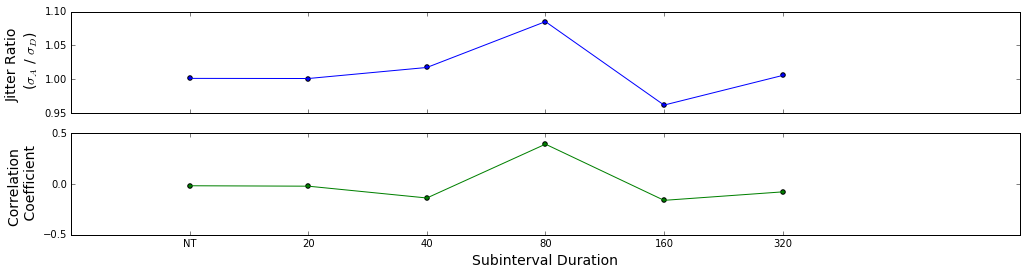

In [176]:
jitter_ratio("J2317+1439", "57273",
            57273.196, 57273.217)

J2234+0944, MJD 57069, 320 second subintervals
sigma_all = 1.89496389868e-07
average sigma_dump = 1.59202820285e-07
jitter ratio = 1.19028287017
masked jitter ratio = 1.19028287017
correlation coefficient = 0.212706724799
weighted correlation coefficient = 0.568261218179
##========
 
J2234+0944, MJD 57069, 160 second subintervals
sigma_all = 2.278135444e-07
average sigma_dump = 1.79790690249e-07
jitter ratio = 1.2671042315
masked jitter ratio = 1.2671042315
correlation coefficient = 0.327667649604
weighted correlation coefficient = 0.301285761193
##========
 
J2234+0944, MJD 57069, 80 second subintervals
sigma_all = 3.09374810381e-07
average sigma_dump = 2.54509387228e-07
jitter ratio = 1.21557327905
masked jitter ratio = 1.21557327905
correlation coefficient = 0.244021824527
weighted correlation coefficient = 0.1947853598
##========
 
J2234+0944, MJD 57069, 40 second subintervals
sigma_all = 4.34894764127e-07
average sigma_dump = 3.54234538129e-07
jitter ratio = 1.22770288415
masked j

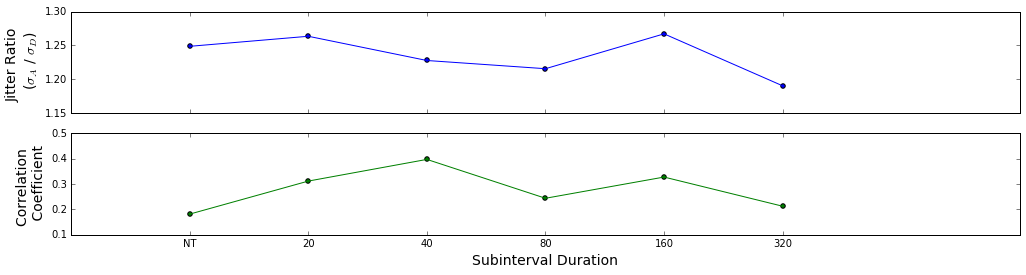

In [177]:
jitter_ratio("J2234+0944", "57069",
            57069.7, 57069.72)

J1640+2224, MJD 57291, 320 second subintervals
sigma_all = 2.50540323735e-07
average sigma_dump = 2.19809119031e-07
jitter ratio = 1.13980859775
masked jitter ratio = 1.13980859775
correlation coefficient = 0.167141375085
weighted correlation coefficient = 0.84779738518
##========
 
J1640+2224, MJD 57291, 160 second subintervals
sigma_all = 3.00923139635e-07
average sigma_dump = 2.46089963688e-07
jitter ratio = 1.22281760347
masked jitter ratio = 1.22281760347
correlation coefficient = 0.111942220615
weighted correlation coefficient = 0.756522910798
##========
 
J1640+2224, MJD 57291, 80 second subintervals
sigma_all = 3.67655466107e-07
average sigma_dump = 3.06746384523e-07
jitter ratio = 1.19856495352
masked jitter ratio = 1.19856495352
correlation coefficient = 0.0461778263826
weighted correlation coefficient = 0.63720598194
##========
 
J1640+2224, MJD 57291, 40 second subintervals
sigma_all = 4.73863591599e-07
average sigma_dump = 3.94712005866e-07
jitter ratio = 1.20052996756
mas

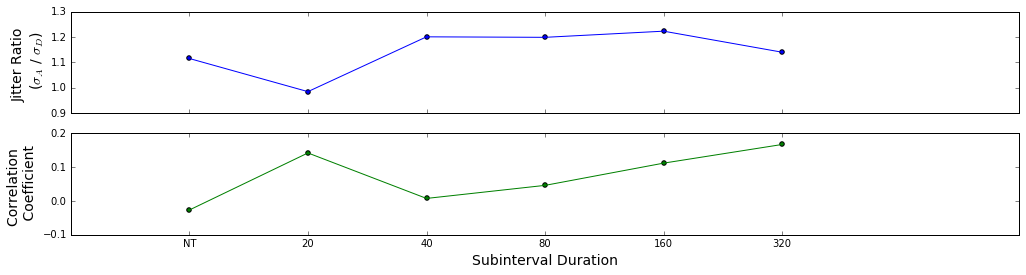

In [178]:
jitter_ratio("J1640+2224", "57291",
            57291.826, 57291.845)

In [181]:
jitter_ratio("J1944+0907", "56627",
            56627.77, 56627.805)

J1944+0907, MJD 56627, 320 second subintervals
sigma_all = 2.07152006302e-05
average sigma_dump = 4.82291792716e-05
jitter ratio = 0.429515926728
masked jitter ratio = 0.429515926728
correlation coefficient = -0.748500288568
weighted correlation coefficient = -0.247386902893
##========
 
J1944+0907, MJD 56627, 160 second subintervals
sigma_all = 2.25008136632e-05
average sigma_dump = 3.01010610348e-05
jitter ratio = 0.74750898771
masked jitter ratio = 0.74750898771
correlation coefficient = 0.0732617300574
weighted correlation coefficient = 0.0668834510835
##========
 
J1944+0907, MJD 56627, 80 second subintervals
sigma_all = 3.33443949134e-05
average sigma_dump = 3.26905850769e-05
jitter ratio = 1.01999994295
masked jitter ratio = 1.01999994295
correlation coefficient = 0.101973490293
weighted correlation coefficient = 0.0651012926555
##========
 
J1944+0907, MJD 56627, 40 second subintervals
sigma_all = 3.72123364776e-05
average sigma_dump = 3.21108337561e-05
jitter ratio = 1.1588716

ValueError: math domain error

In [180]:
jitter_ratio("J2234+0611", "56843",
            56843.315, 56843.335)

J2234+0611, MJD 56843, 320 second subintervals
sigma_all = 8.91569032806e-06
average sigma_dump = 7.37855225854e-06
jitter ratio = 1.2083251586
masked jitter ratio = 1.2083251586
correlation coefficient = 0.103160765487
weighted correlation coefficient = 0.160284818722
##========
 
J2234+0611, MJD 56843, 160 second subintervals
sigma_all = 1.21603370744e-05
average sigma_dump = 9.8633809926e-06
jitter ratio = 1.23287715273
masked jitter ratio = 1.23287715273
correlation coefficient = 0.175971357135
weighted correlation coefficient = 0.119858849858
##========
 
J2234+0611, MJD 56843, 80 second subintervals
sigma_all = 1.9013686857e-05
average sigma_dump = 1.60257157749e-05
jitter ratio = 1.18644852586
masked jitter ratio = 1.18644852586
correlation coefficient = 0.0462870874128
weighted correlation coefficient = 0.00693974307886
##========
 
J2234+0611, MJD 56843, 40 second subintervals
sigma_all = 2.62303421774e-05
average sigma_dump = 2.16977636819e-05
jitter ratio = 1.20889611307
mas

ValueError: math domain error

J2229+2643, MJD 57234, 320 second subintervals
sigma_all = 1.01584878942e-06
average sigma_dump = 2.762645084e-06
jitter ratio = 0.367708756836
masked jitter ratio = 1.19215519221
correlation coefficient = -0.0321194527183
weighted correlation coefficient = 0.0616727906945
##========
 
J2229+2643, MJD 57234, 160 second subintervals
sigma_all = 1.32632722949e-06
average sigma_dump = 2.13264438495e-06
jitter ratio = 0.621916733443
masked jitter ratio = 0.621916733443
correlation coefficient = 0.0612146566223
weighted correlation coefficient = 0.125855747317
##========
 
J2229+2643, MJD 57234, 80 second subintervals
sigma_all = 7.28480556269e-06
average sigma_dump = 4.20763111572e-06
jitter ratio = 1.73133180223
masked jitter ratio = 1.73133180223
correlation coefficient = 0.072480601191
weighted correlation coefficient = 0.0398812019984
##========
 
J2229+2643, MJD 57234, 40 second subintervals
sigma_all = 1.17433736297e-05
average sigma_dump = 6.26113887877e-06
jitter ratio = 1.87559705

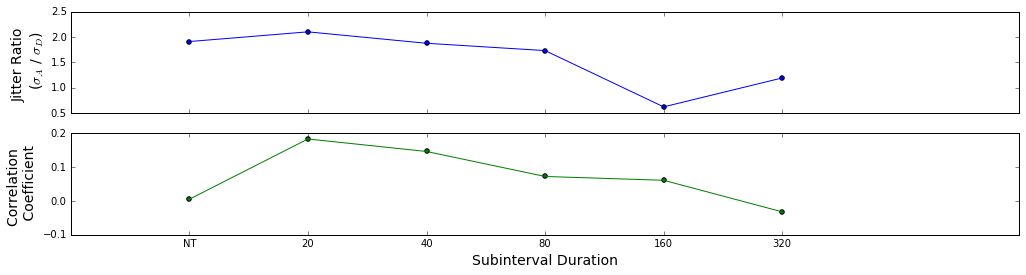

In [179]:
jitter_ratio("J2229+2643", "57234", 57234.255, 57234.275)

J0023+0923, MJD 56023, 320 second subintervals
sigma_all = 3.60874362523e-07
average sigma_dump = 3.52730125717e-07
jitter ratio = 1.0230891444
masked jitter ratio = 1.0230891444
correlation coefficient = 0.125944333021
weighted correlation coefficient = -0.124991976507
##========
 
J0023+0923, MJD 56023, 160 second subintervals
sigma_all = 4.14528648345e-07
average sigma_dump = 3.84843178507e-07
jitter ratio = 1.07713653638
masked jitter ratio = 1.07713653638
correlation coefficient = 0.411798494447
weighted correlation coefficient = 0.332623793601
##========
 
J0023+0923, MJD 56023, 80 second subintervals
sigma_all = 4.94718556922e-07
average sigma_dump = 4.53724114577e-07
jitter ratio = 1.09035103277
masked jitter ratio = 1.09035103277
correlation coefficient = 0.11642325302
weighted correlation coefficient = 0.439244289771
##========
 
J0023+0923, MJD 56023, 40 second subintervals
sigma_all = 6.8972793334e-07
average sigma_dump = 5.6407222134e-07
jitter ratio = 1.22276529006
masked

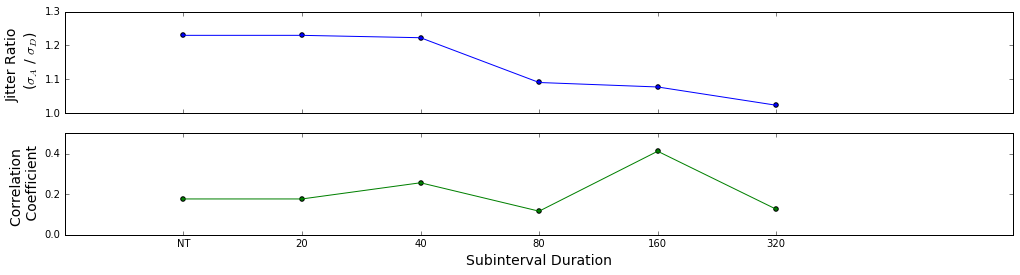

In [182]:
jitter_ratio("J0023+0923", "56023", 56023.66, 56023.68)

J1738+0333, MJD 57124, 320 second subintervals
sigma_all = 3.36860400923e-07
average sigma_dump = 3.18892749748e-07
jitter ratio = 1.05634386856
masked jitter ratio = 1.05634386856
correlation coefficient = 0.107336413654
weighted correlation coefficient = 0.86578201259
##========
 
J1738+0333, MJD 57124, 160 second subintervals
sigma_all = 4.1877507144e-07
average sigma_dump = 4.14059932351e-07
jitter ratio = 1.01138757634
masked jitter ratio = 1.01138757634
correlation coefficient = -0.0848666822758
weighted correlation coefficient = 0.720762075586
##========
 
J1738+0333, MJD 57124, 80 second subintervals
sigma_all = 5.51075574083e-07
average sigma_dump = 4.92082321532e-07
jitter ratio = 1.11988492569
masked jitter ratio = 1.11988492569
correlation coefficient = 0.0109126997516
weighted correlation coefficient = 0.295940224352
##========
 
J1738+0333, MJD 57124, 40 second subintervals
sigma_all = 7.49003924014e-07
average sigma_dump = 6.59139121944e-07
jitter ratio = 1.13633662315
m

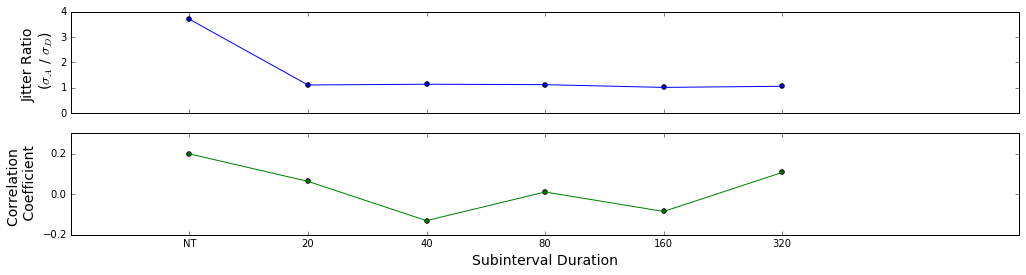

In [183]:
jitter_ratio("J1738+0333", "57124", 57124.352, 57124.37)

J2214+3000, MJD 56739, 320 second subintervals
sigma_all = 1.68829374526e-05
average sigma_dump = 6.98609766536e-05
jitter ratio = 0.241664778555
masked jitter ratio = 0.241664778555
correlation coefficient = 0.215759636278
weighted correlation coefficient = 0.461977986733
##========
 
J2214+3000, MJD 56739, 160 second subintervals
sigma_all = 2.44270286944e-05
average sigma_dump = 5.90451646276e-05
jitter ratio = 0.413700746681
masked jitter ratio = 0.413700746681
correlation coefficient = 0.515806162599
weighted correlation coefficient = 0.325035619341
##========
 
J2214+3000, MJD 56739, 80 second subintervals
sigma_all = 3.82246330354e-05
average sigma_dump = 4.33566618257e-05
jitter ratio = 0.881632289613
masked jitter ratio = 0.881632289613
correlation coefficient = 0.669399673152
weighted correlation coefficient = 0.636952781992
##========
 
J2214+3000, MJD 56739, 40 second subintervals
sigma_all = 4.4848379189e-05
average sigma_dump = 5.49375658654e-05
jitter ratio = 0.816351771

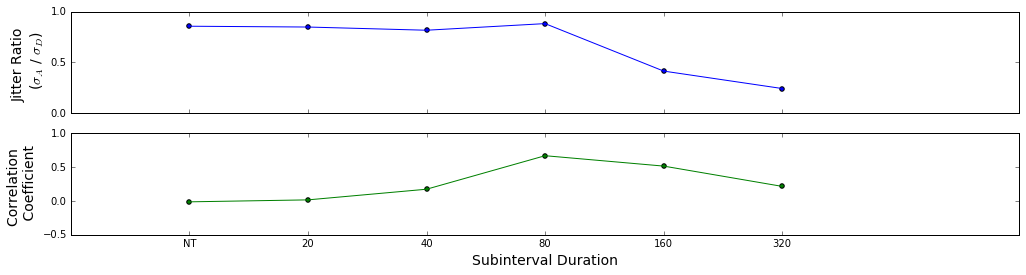

In [184]:
jitter_ratio("J2214+3000", "56739", 56739.63, 56739.66)